# Python2 Notebook for Text Detection in Scene or Document

In [1]:
%matplotlib inline
import keras
import tensorflow as tf
import numpy as np 
import cv2
from matplotlib import pyplot
import os
import sys
np.set_printoptions(3, suppress=True)
print "keras.version =", keras.__version__
print "tensorflow.version =", tf.__version__

Using TensorFlow backend.


keras.version = 2.0.7
tensorflow.version = 1.1.0


# Set Text Detection Path

In [3]:
repo_root = os.path.join( os.getcwd(), os.path.pardir )
print "git repo root =", repo_root
assert os.path.isdir( repo_root ), "ERROR: can't locate git repo for text detection"
model_dir = os.path.join( repo_root, 'model' )
scriptID_weight = os.path.join( model_dir, 'sciptIDModel.h5' )
assert os.path.isfile( scriptID_weight ), "ERROR: can't locate script-ID classification model"
textDet_weight  = os.path.join( model_dir, 'textDetModel.h5' )
assert os.path.isfile( textDet_weight ), "ERROR: can't locate text detection model"

data_dir  = os.path.join( repo_root, 'data' )
lib_dir   = os.path.join( repo_root, 'lib' )
sys.path.insert( 0, lib_dir )
import textDetCore

git repo root = /nas/medifor/yue_wu/thirdparty/TextDetWithScriptID/notebook/..


# Load Models with Pretrained Weights

## 1. scriptID model

The scriptID model's output format is a `nb_samples x 7` array, 
where the 1st dimension stands for the sample axis, 
and the 2nd one stands for the scriptID probability of each known script.

More precisely, the seven scriptID classes are:

| **scriptID index** | **scriptID name** | **Country** |
|:------------------:|:-----------------:|:-----------:|
| 0 | NonText | N/A |
| 1 | Latin | US, UK, etc. |
| 2 | Hebrew | Israel |
| 3 | Cyrillic | Russia, Ukraine, etc. | 
| 4 | Arabic | Iran, Saudi Arabia, etc. |
| 5 | Chinese | China, HongKong, etc. |
| 6 | TextButUnknown | N/A |

In [4]:
scriptID_model = textDetCore.create_scriptID_model()
scriptID_model.load_weights( scriptID_weight )
print scriptID_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_in (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
scriptIDb1c1-c (Conv2D)      (None, None, None, 16)    2368      
_________________________________________________________________
scriptIDb1c1-bn (BatchNormal (None, None, None, 16)    64        
_________________________________________________________________
scriptIDb1c1-re (Activation) (None, None, None, 16)    0         
_________________________________________________________________
scriptIDb1c2-c (Conv2D)      (None, None, None, 16)    272       
_________________________________________________________________
scriptIDb1c2-bn (BatchNormal (None, None, None, 16)    64        
_________________________________________________________________
scriptIDb1c2-re (Activation) (None, None, None, 16)    0         
__________

# 2. textDet model
The textDet model's output format is a `nb_samples x height x width x 3` array, 
where the last dimension stands for the text probabilities of 
- non-text/background
- border
- text

In [5]:
textDet_model = textDetCore.create_textDet_model()
textDet_model.load_weights( textDet_weight )
print textDet_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
image_in (InputLayer)            (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
textDetb1c1-c (Conv2D)           (None, None, None, 16 2368        image_in[0][0]                   
____________________________________________________________________________________________________
textDetb1c1-bn (BatchNormalizati (None, None, None, 16 64          textDetb1c1-c[0][0]              
____________________________________________________________________________________________________
textDetb1c1-re (Activation)      (None, None, None, 16 0           textDetb1c1-bn[0][0]             
___________________________________________________________________________________________

# Load Pre- and Post- Utils

In [6]:
# 1. non-mandatory utils
from textDetUtils import read_image, bwlabel, decode_text_bboxes, visualize_text_proba_map, visualize_individual_regions
# 2. mandatory utils
from textDetUtils import convert_imageArray_to_inputTensor, decode_scriptID

## Sample Decoder

Both TextDet and ScriptID models provide raw results, it, therefore, requires necessary post-processing to convert these raw outputs to a desired format. Below we provide a simple decoder supporting the features:

1. read image from a file path or a web-link
2. resize an image
3. thresholds to reject low confident text regions in terms of
    - text region size
    - text probability
4. locate each indiviudal text region and rectify it
5. identify the dominant script ID for an image or each individual text region
6. visualize text probability map and all rectified regions

Feel free to add new features to this simple decoder, e.g. 
- dump rectified region image to disk
- save detection info, including region bounding box, text probability, scriptID probability, etc.

**NOTE**: The provided decoder is a very basic one, and it can be improved at least in the following aspects:
1. self adaptive resize factor: Our training data is dominant by samples with line height in range (20,30) pixel. It is possible to make a two-pass decoder, where the 1st pass is to estimate the page line height, and the 2nd pass is to repropress the adjusted input.
2. better text region identification: The simple decoder only uses the simplest connected component analysis on the text-class map (blue pixels in a text detector output). However, the border-class map (green pixels in a text detector output) is also very useful, especially in separating adjacent text regions. 


In [7]:
def simple_decoder( file_path, 
                    textDet_model,
                    scriptID_model,
                    resize_factor = 2.,
                    proba_threshold = .33,
                    area_threshold = 100.,
                    visualize = True ) :
    # 1. read image
    img = read_image( file_path )
    # 1.b resize image if necessary
    ih, iw = img.shape[:2]
    if ( resize_factor != 1 ) :
        nh, nw = int(ih*resize_factor), int(iw*resize_factor)
        img = cv2.resize( img, (nw, nh) )
    # 2. convert input image to network tensor
    ih, iw = img.shape[:2]
    x = convert_imageArray_to_inputTensor( img )
    # 3. predict text probability map
    text_proba  = textDet_model.predict(x)
    text_proba = text_proba[0] # since we always take one sample at a time
    # 3.b sample connected component analysis based decoder
    membership = text_proba.argmax( axis = -1 )
    regions = bwlabel( membership == 2, neighbors=8 )
    decoded_results = decode_text_bboxes( img, text_proba[...,-1], regions )
    # 4. predict script ID
    script_proba = scriptID_model.predict(x[:,::2,::2])
    scriptID = decode_scriptID( script_proba )[0]
    # 5. visualize results
    if ( visualize ) :
        visualize_text_proba_map( img, text_proba[:ih,:iw], scriptID )
        visualize_individual_regions( decoded_results, proba_threshold, area_threshold  )
    # 6. save detection results 
    # modify this section to save additional/different information
    header = ','.join([ 'topLeftX', 'topLeftY', 'botRightX', 'botRightY', 'boxProba' ])
    det_results = [ header ]
    for idx, (bbox, proba, wrapped_image) in enumerate( decoded_results ):
        if ( proba < proba_threshold ) :
            continue
        upper_left, upper_right, lower_right, lower_left = bbox
        area = np.product( lower_right - upper_left )
        if ( area < area_threshold ) :
            continue
        upper_left = [ '{:d}'.format(int(val/resize_factor)) for val in upper_left ]
        lower_right = [ '{:d}'.format(int(val/resize_factor)) for val in lower_right ]
        this_line = upper_left + lower_right + [ '{:.3f}'.format(proba) ]
        this_line = ','.join( this_line )
        det_results.append( this_line )
    det_results = '\n'.join( det_results )
    return det_results

# Text and scriptID detection for a web image

topLeftX,topLeftY,botRightX,botRightY,boxProba
47,59,127,84,0.839
43,79,131,104,0.857
55,103,121,121,0.836


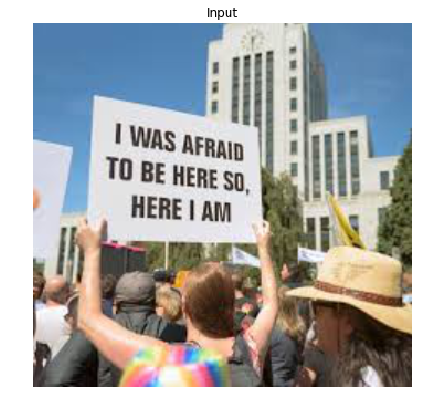

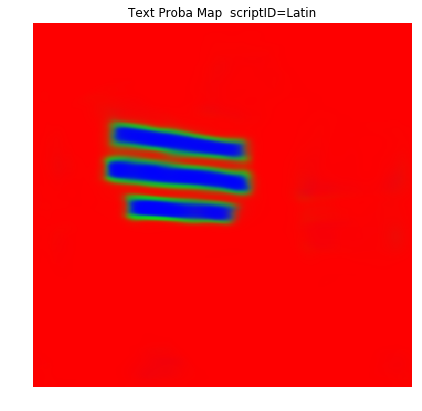

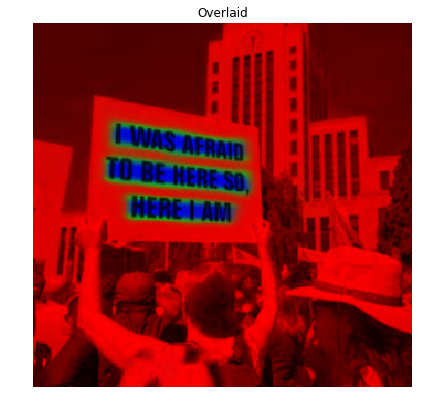

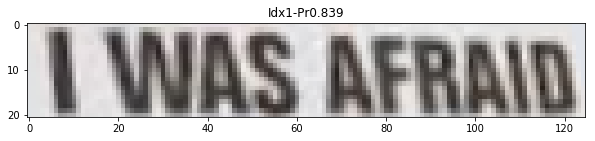

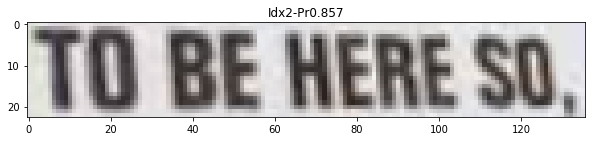

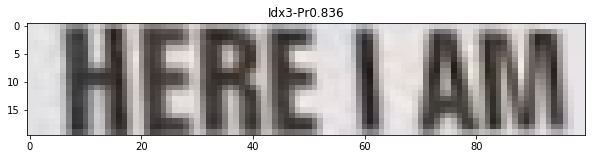

In [12]:
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRSnHUc4igGIJaH0iPFsIsWpFGk2VZcfghhLQ3mg_4cdXxrSagS'
det_results = simple_decoder( url,
                              textDet_model,
                              scriptID_model,
                              resize_factor = 1.5,
                              proba_threshold = .5,
                              area_threshold = 100.,
                              visualize = True )
print det_results

# Text and scriptID detection for a local image

/nfs/isicvlnas01/share/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: skip 78 proba = 0.382915 area = 6
INFO: skip 79 proba = 0.342357 area = 3
INFO: skip 80 proba = 0.387955 area = 13
INFO: skip 81 proba = 0.342428 area = 7
INFO: skip 82 proba = 0.396578 area = 16


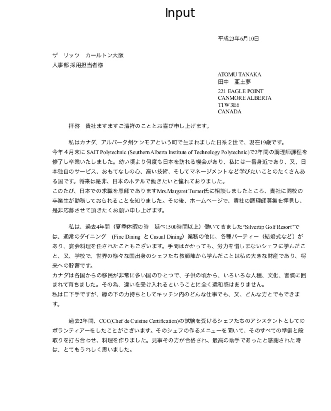

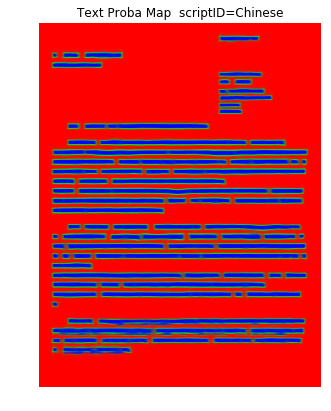

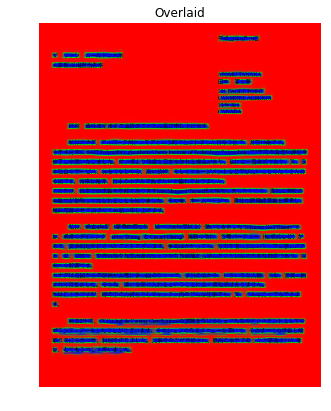

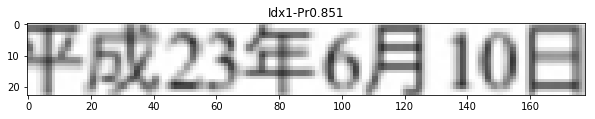

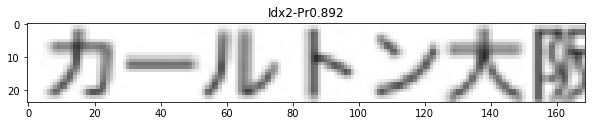

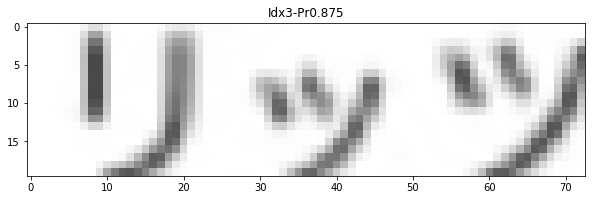

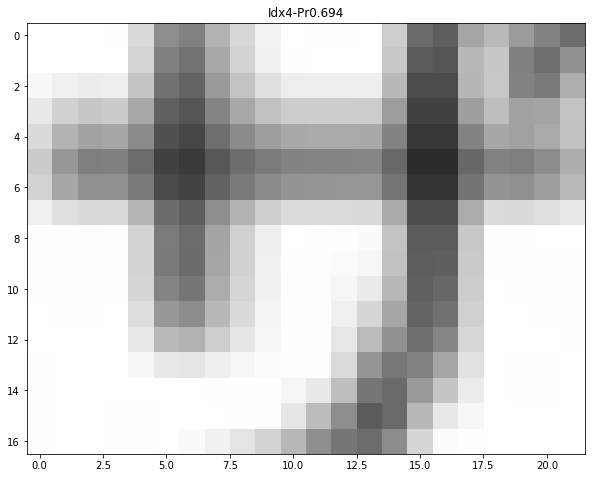

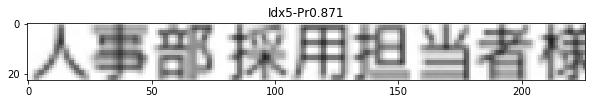

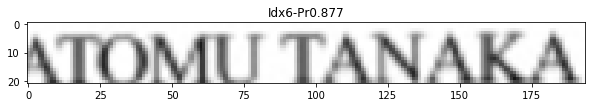

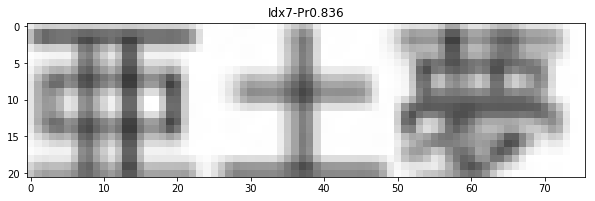

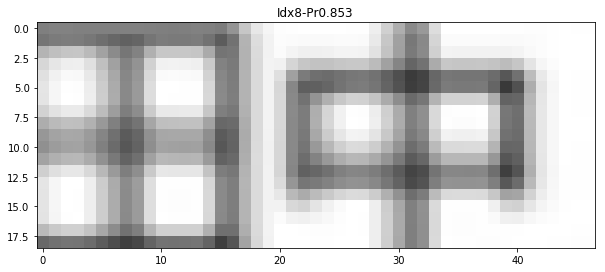

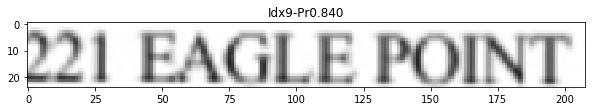

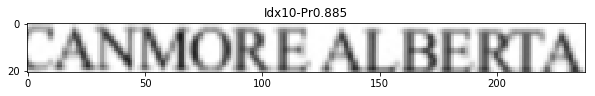

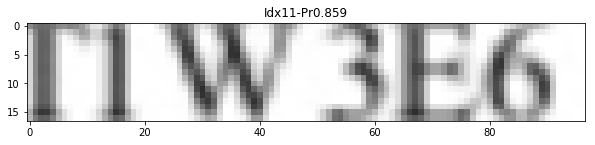

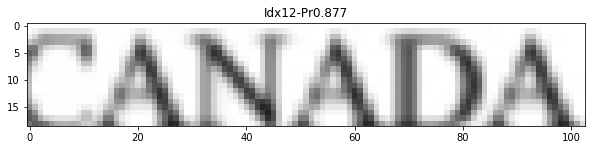

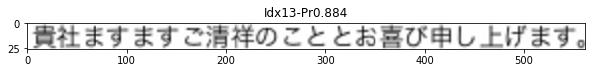

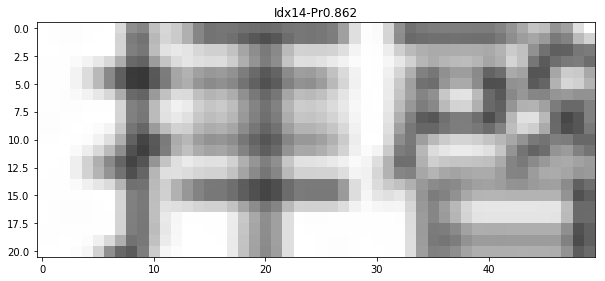

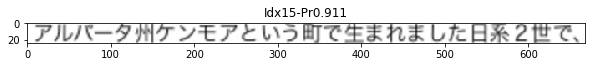

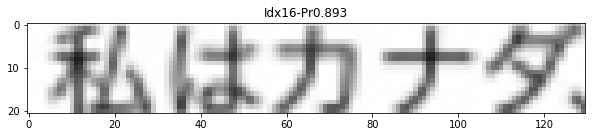

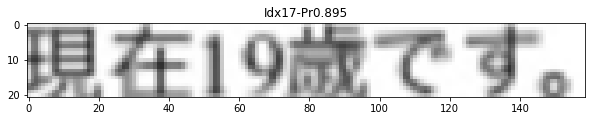

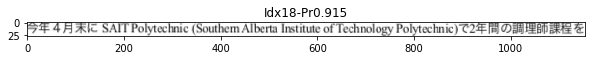

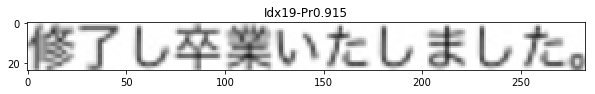

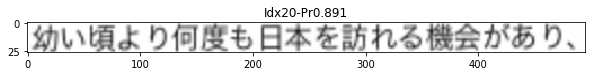

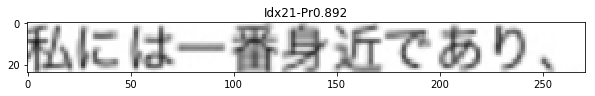

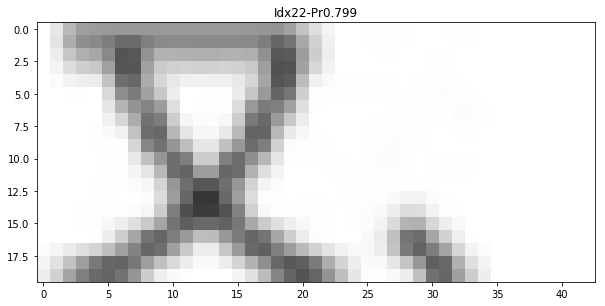

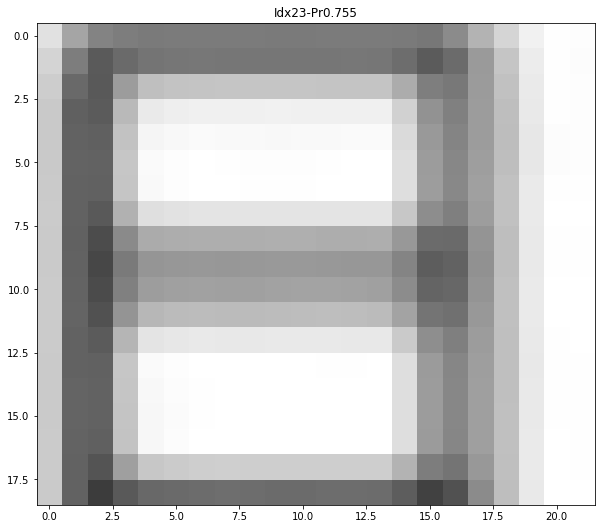

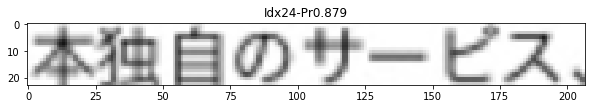

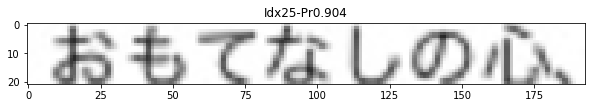

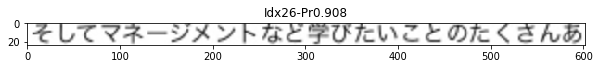

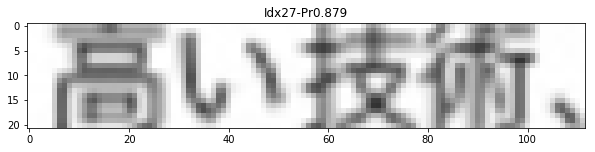

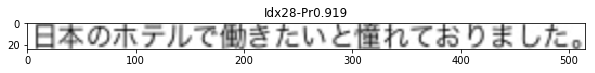

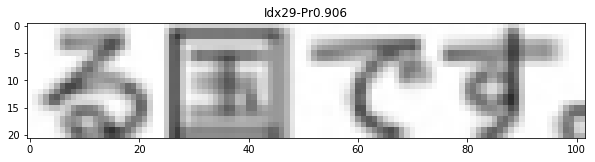

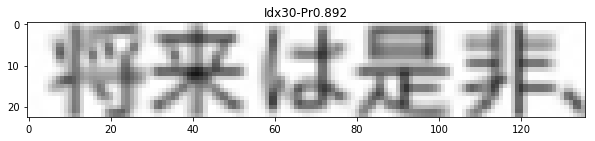

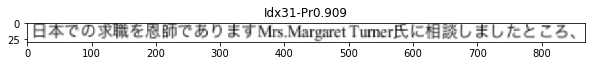

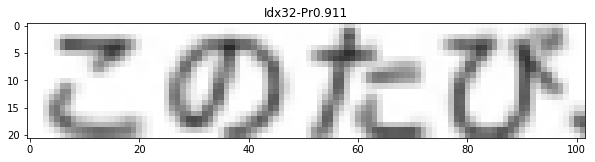

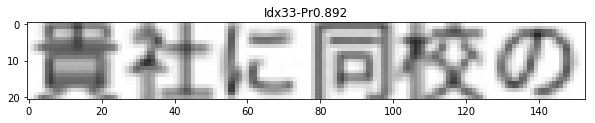

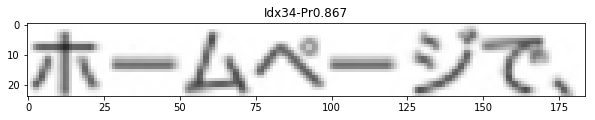

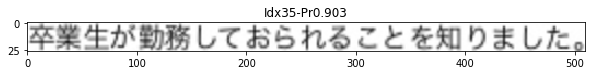

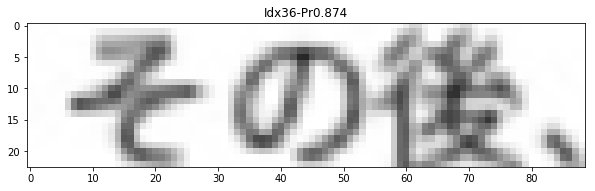

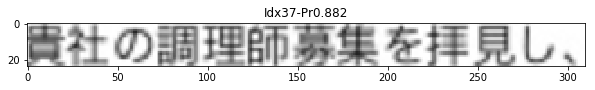

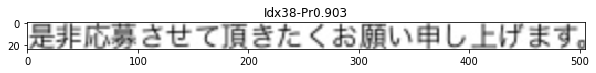

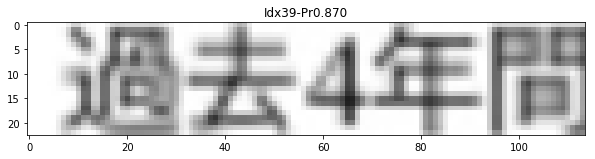

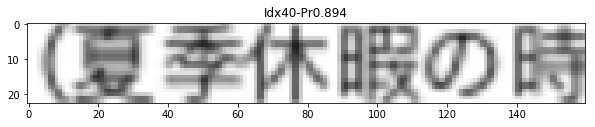

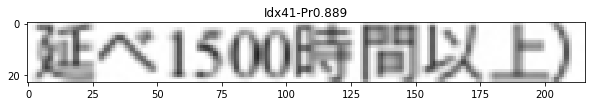

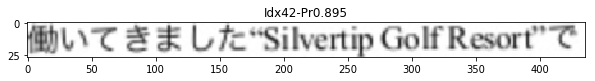

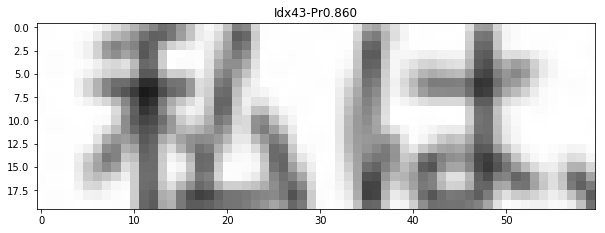

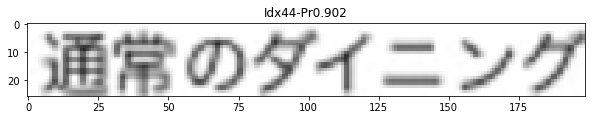

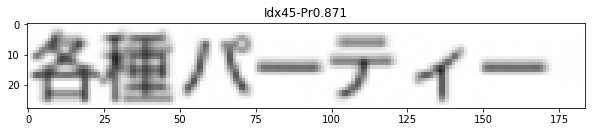

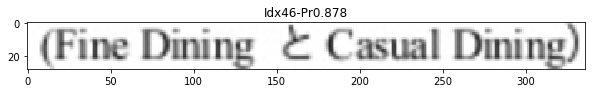

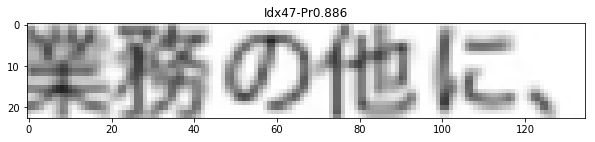

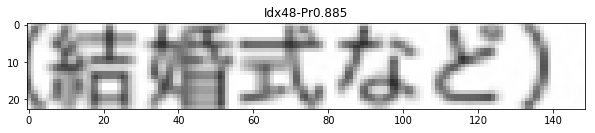

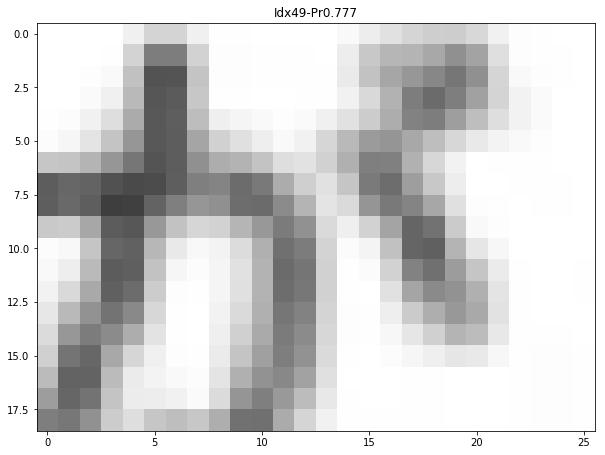

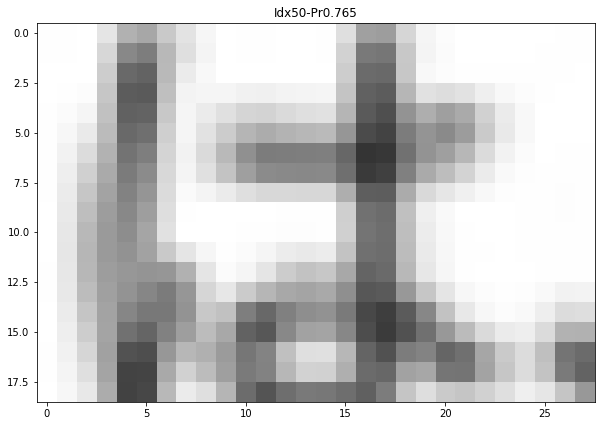

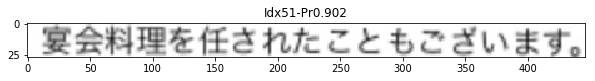

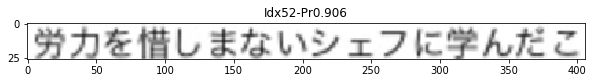

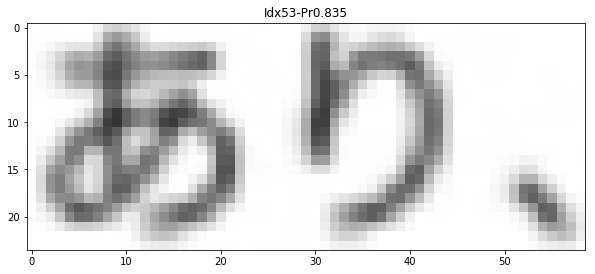

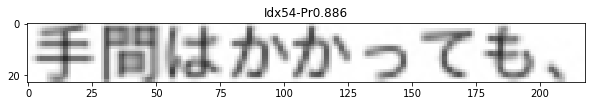

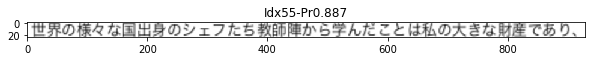

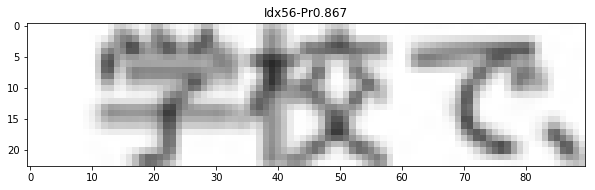

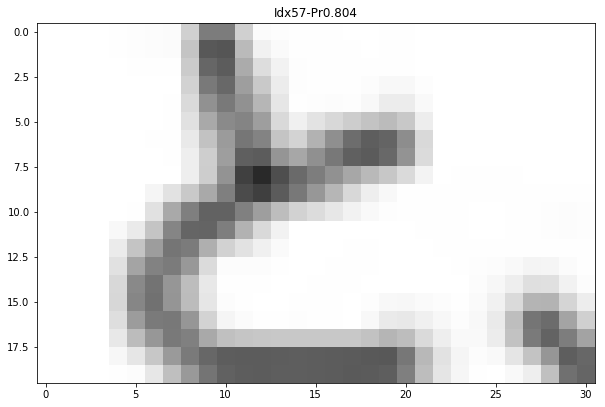

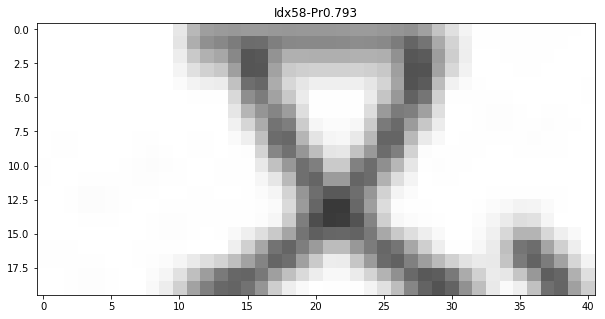

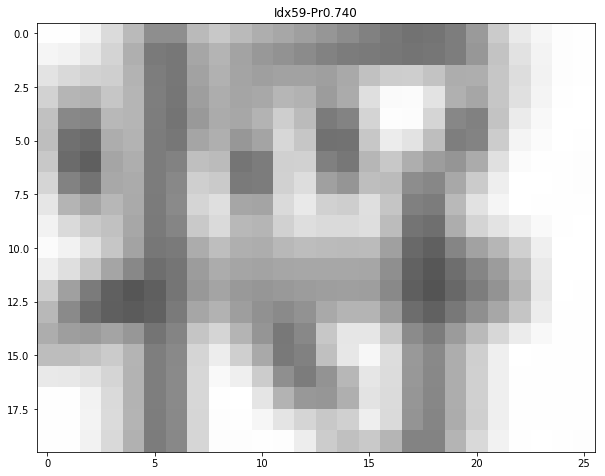

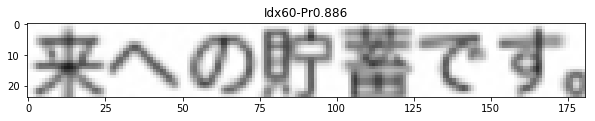

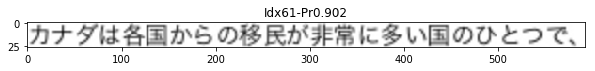

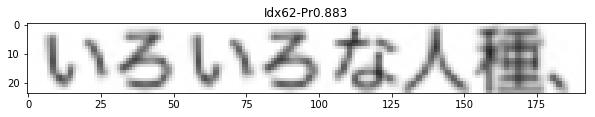

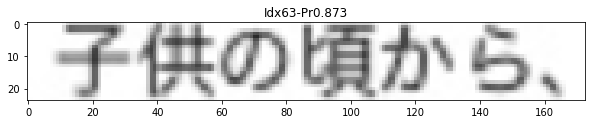

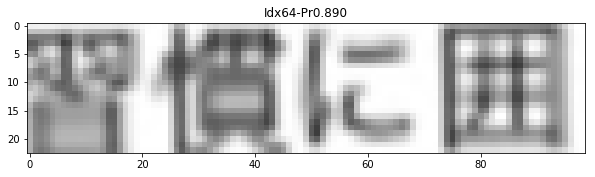

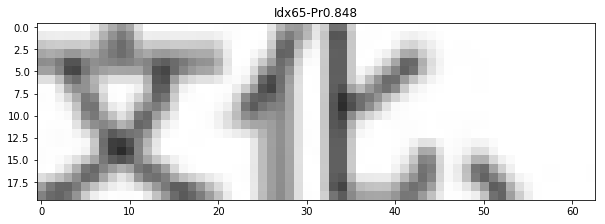

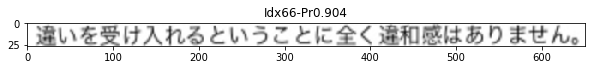

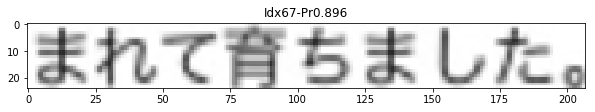

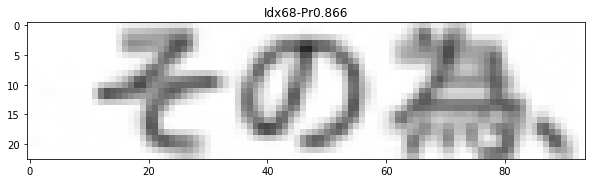

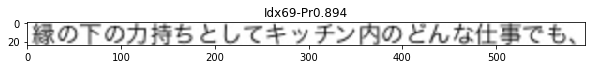

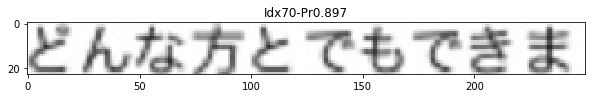

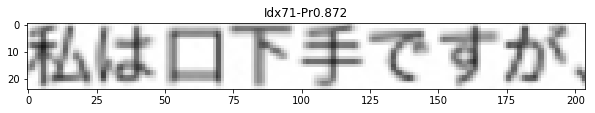

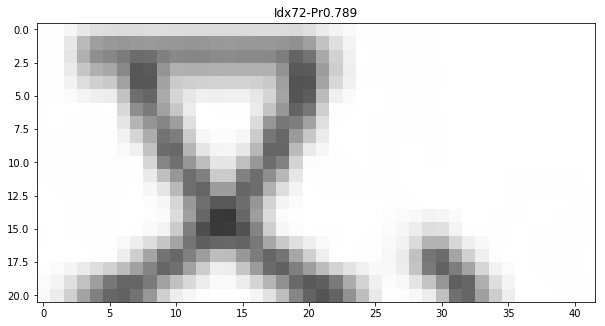

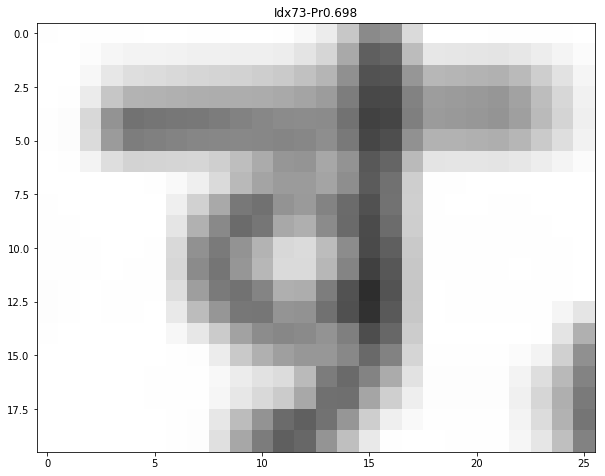

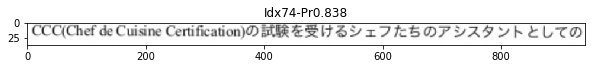

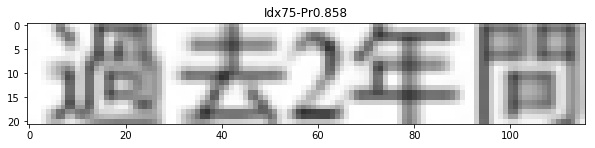

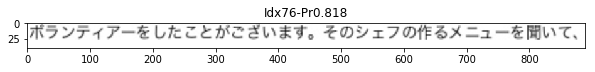

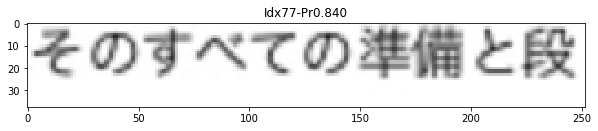

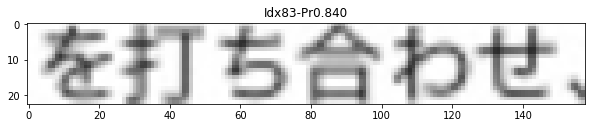

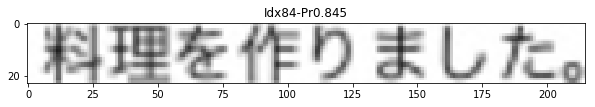

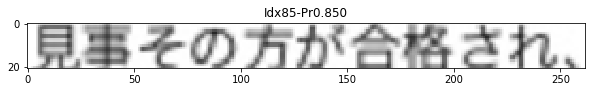

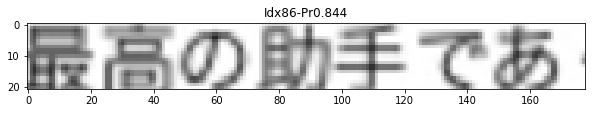

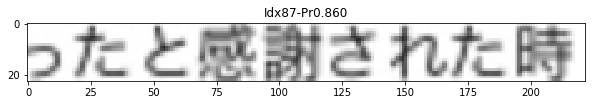

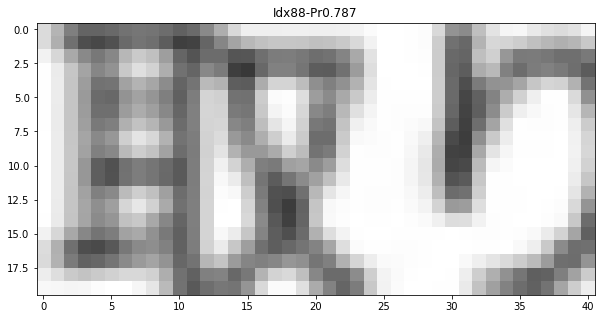

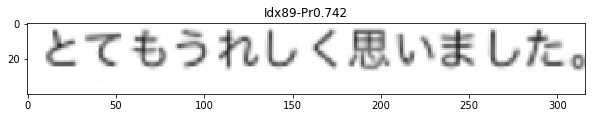

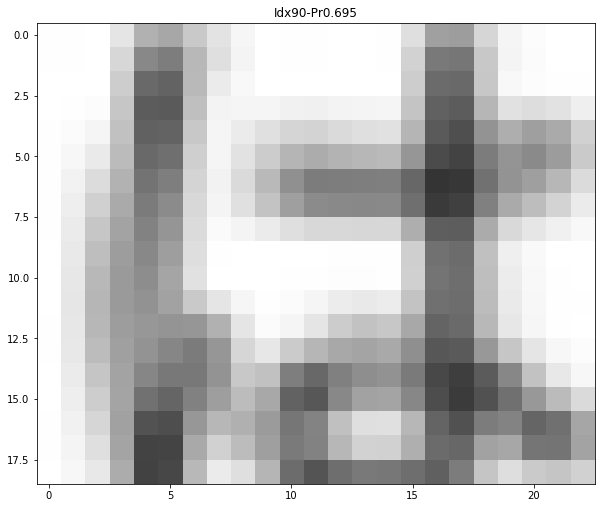

In [10]:
file_path = os.path.join( data_dir, 'JAP_atomu-tanaka-japanese-cover-letter-1-638.jpg' )
det_results = simple_decoder( file_path,
                              textDet_model,
                              scriptID_model,
                              resize_factor = 2,
                              proba_threshold = .5,
                              area_threshold = 100.,
                              visualize = True )

# Remark

Though you see fancy perspective transform based corrections for text regions, they are not included in `det_results`.  Actually, `det_results` only include rectangular text bounding boxes. 